In [1]:
# pip install "numpy<2" --force-reinstall
#pip uninstall numpy scipy opencv-python -y
# pip install numpy==1.26.4 scipy==1.13.1 opencv-python==4.10.0.84

In [2]:
import os
import random
from pathlib import Path
import re
import shutil
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import SimpleITK as sitk   # leitura NRRD
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2


imgs_path = Path("./images")
rescaled_folder = "2-Rescaled_256_NRRD"
seg_folder = "3-Segmentation_NRRD"

print("imgs_path:", imgs_path)
print("Expecting rescaled exams in:", imgs_path / rescaled_folder)
print("Expecting segmentations in:", imgs_path / seg_folder)

imgs_path: images
Expecting rescaled exams in: images\2-Rescaled_256_NRRD
Expecting segmentations in: images\3-Segmentation_NRRD


In [3]:
# ============================================================
# Funções auxiliares para processamento NRRD, seleção de fatia,
# recorte (crop) e salvamento de patches
# ============================================================

def resample_mask_to_exam(mask_sitk, exam_sitk):
    """Resample mask to exam geometry using nearest neighbor."""
    return sitk.Resample(
        mask_sitk,
        exam_sitk.GetSize(),
        sitk.Transform(),
        sitk.sitkNearestNeighbor,
        exam_sitk.GetOrigin(),
        exam_sitk.GetSpacing(),
        exam_sitk.GetDirection(),
        0,
        mask_sitk.GetPixelID()
    )

def detect_slice_axis_and_index(mask_array):
    """
    Detecta eixo de slices (aquele com menor dimensão)
    e retorna índice da fatia com maior área de máscara.
    Works for mask_array with shape (z,y,x) or (y,x,z) etc.
    """
    # choose axis with smallest length (usually depth)
    slice_axis = int(np.argmin(mask_array.shape))
    # sum over all axes except slice_axis
    axes = tuple(i for i in range(mask_array.ndim) if i != slice_axis)
    areas = mask_array.sum(axis=axes)
    slice_idx = int(np.argmax(areas))
    return slice_axis, slice_idx

def extract_slice_from_volume(volume, slice_axis, slice_idx):
    """Return 2D slice according to axis and index. volume is numpy array."""
    if slice_axis == 0:
        return volume[slice_idx, :, :]
    elif slice_axis == 1:
        return volume[:, slice_idx, :]
    elif slice_axis == 2:
        return volume[:, :, slice_idx]
    else:
        raise ValueError("slice_axis must be 0/1/2")

def crop_with_padding(image_slice, mask_slice, window_size=150):
    """Crop a square patch centered on the mask (non-zero region)."""
    coords = np.argwhere(mask_slice > 0)
    if coords.size == 0:
        return None
    center = coords.mean(axis=0)
    cx, cy = int(center[0]), int(center[1])
    half = window_size // 2
    x_min = max(0, cx - half)
    y_min = max(0, cy - half)
    x_max = min(image_slice.shape[0], cx + half)
    y_max = min(image_slice.shape[1], cy + half)
    cropped = image_slice[x_min:x_max, y_min:y_max]
    # pad if needed
    h, w = cropped.shape
    pad_h = window_size - h
    pad_w = window_size - w
    if pad_h > 0 or pad_w > 0:
        cropped = np.pad(cropped,
                         ((pad_h//2, pad_h - pad_h//2),
                          (pad_w//2, pad_w - pad_w//2)),
                         mode='constant', constant_values=0)
    return cropped

def normalize_patch_for_save(patch):
    """Normalize patch robustly for saving as uint8 PNG.
       Uses percentile clipping and linear scaling. Adjust if needed."""
    if patch is None:
        return None
    # clip high outliers
    high = np.percentile(patch, 99)
    low = np.percentile(patch, 1)
    patch = np.clip(patch, low, high)
    # scale to 0-255
    patch = patch.astype(np.float32)
    patch = (patch - patch.min()) / (np.ptp(patch) + 1e-8)
    patch = (patch * 255.0).astype(np.uint8)
    return patch


In [4]:
from PIL import Image

output_root = imgs_path / "patches_output_nrrd_masked"
classes = ["BENIGN", "MALIGNANT"]
PATCH_SIZE = 150

for cls in classes:
    (output_root / cls).mkdir(parents=True, exist_ok=True)

exams_root = imgs_path / rescaled_folder
masks_root = imgs_path / seg_folder

if not exams_root.exists() or not masks_root.exists():
    print("Não encontrei pastas NRRD esperadas:", exams_root, masks_root)
else:
    exams = sorted(exams_root.glob("*.nrrd"))
    masks = sorted(masks_root.glob("*.nrrd"))
    print(f"Encontrados {len(exams)} exames e {len(masks)} máscaras (NRRD).")

    masks_by_patient = defaultdict(list)
    for mpath in masks:
        stem = mpath.stem.replace('.seg','')
        m = re.search(r"P0*?(\d+)[_\-\. ]*L0*?(\d+)", stem, re.IGNORECASE)
        if not m:
            # try other pattern
            m2 = re.search(r"P0*?(\d+)", stem, re.IGNORECASE)
            if not m2:
                print("ERRO ao parsear mascara:", mpath.name)
                continue
            pid = m2.group(1)
            vertebra = 0
        else:
            pid, vertebra = m.groups()
        masks_by_patient[str(int(pid))].append((int(vertebra), mpath))

    for k in masks_by_patient:
        masks_by_patient[k].sort()

    # Processa os exames um por um
    for exam_path in exams:
        m = re.search(r"P0*?(\d+)", exam_path.stem, re.IGNORECASE)
        if not m:
            print("Exame sem Pid:", exam_path.name)
            continue
        pid = str(int(m.group(1)))
        if pid not in masks_by_patient:
            print(f"Aviso: nenhuma máscara encontrada para paciente P{pid}")
            continue

        # Lendo exame
        exam = sitk.ReadImage(str(exam_path))
        exam_arr = sitk.GetArrayFromImage(exam)  # numpy

        for vertebra, mask_path in masks_by_patient[pid]:
            mask = sitk.ReadImage(str(mask_path))
            mask_res = resample_mask_to_exam(mask, exam)
            mask_arr = sitk.GetArrayFromImage(mask_res)

            slice_axis, slice_idx = detect_slice_axis_and_index(mask_arr)
            img_slice = extract_slice_from_volume(exam_arr, slice_axis, slice_idx)
            mask_slice = extract_slice_from_volume(mask_arr, slice_axis, slice_idx)

            # apply mask to image (binary mask >0)
            masked = img_slice * (mask_slice > 0)

            patch = crop_with_padding(masked, mask_slice, PATCH_SIZE)
            if patch is None:
                print(f"[pular] máscara vazia em {mask_path.name}")
                continue

            save_patch = normalize_patch_for_save(patch)
            out_name = f"P{pid}_L{vertebra}.png"
            # determine class (look into original folder structure)
            # try to find class by searching mask_path parent OR exam_path parent
            cls_guess = None
            for cls in classes:
                if str(mask_path).find(cls) != -1 or str(exam_path).find(cls) != -1:
                    cls_guess = cls
                    break
            if cls_guess is None:
                cls_guess = "BENIGN"  # default fallback
            out_dir = output_root / cls_guess
            out_dir.mkdir(parents=True, exist_ok=True)
            Image.fromarray(save_patch).save(out_dir / out_name)
            print("Saved", out_dir / out_name)

Encontrados 91 exames e 130 máscaras (NRRD).
Saved images\patches_output_nrrd_masked\BENIGN\P1_L1.png
Saved images\patches_output_nrrd_masked\BENIGN\P10_L1.png
Saved images\patches_output_nrrd_masked\BENIGN\P10_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P10_L3.png
Saved images\patches_output_nrrd_masked\BENIGN\P10_L4.png
Saved images\patches_output_nrrd_masked\BENIGN\P10_L5.png
Saved images\patches_output_nrrd_masked\BENIGN\P11_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P12_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P13_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P14_L1.png
Saved images\patches_output_nrrd_masked\BENIGN\P14_L3.png
Saved images\patches_output_nrrd_masked\BENIGN\P15_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P15_L4.png
Saved images\patches_output_nrrd_masked\BENIGN\P16_L1.png
Saved images\patches_output_nrrd_masked\BENIGN\P16_L2.png
Saved images\patches_output_nrrd_masked\BENIGN\P17_L3.png
Saved images\patches_output_

In [5]:
# ============================================================
# PASSO 6 — Organizar dataset_final (train / val / test) por paciente
# ============================================================

import json

source_root = imgs_path / "patches_output_nrrd_masked"
target_root = imgs_path / "dataset_final"
classes = ["BENIGN", "MALIGNANT"]

splits = {"train": 0.7, "val": 0.15, "test": 0.15}

# create dirs
for s in splits:
    for cls in classes:
        (target_root / s / cls).mkdir(parents=True, exist_ok=True)

# group by patient id
patients_by_class = defaultdict(list)
for cls in classes:
    for p in (source_root / cls).glob("*.png"):
        m = re.search(r"P0*?(\d+)", p.name, re.IGNORECASE)
        if not m:
            continue
        pid = int(m.group(1))
        patients_by_class[cls].append((pid, p))

# reorganize to list of images per patient
images_by_class_patient = defaultdict(lambda: defaultdict(list))
for cls in classes:
    for pid, ppath in patients_by_class[cls]:
        images_by_class_patient[cls][pid].append(ppath)

# split patients
split_patients = {cls: {} for cls in classes}
for cls in classes:
    patient_ids = sorted(list(images_by_class_patient[cls].keys()))
    random.shuffle(patient_ids)
    n = len(patient_ids)
    n_train = int(splits["train"] * n)
    n_val = int(splits["val"] * n)
    train_p = patient_ids[:n_train]
    val_p = patient_ids[n_train:n_train + n_val]
    test_p = patient_ids[n_train + n_val:]
    split_patients[cls]['train'] = train_p
    split_patients[cls]['val'] = val_p
    split_patients[cls]['test'] = test_p

    # copy files
    for split_name, plist in [('train', train_p), ('val', val_p), ('test', test_p)]:
        for pid in plist:
            for src in images_by_class_patient[cls][pid]:
                dst = target_root / split_name / cls / src.name
                shutil.copy2(src, dst)

# save split mapping for reproducibility
with open(imgs_path / "splits_by_patient.json", "w") as f:
    json.dump(split_patients, f, indent=2)

# quick report
for cls in classes:
    print(cls)
    for s in ['train','val','test']:
        path = target_root / s / cls
        count = len(list(path.glob("*.png")))
        print(f"  {s}: {count} images ({len(split_patients[cls][s])} patients)")


BENIGN
  train: 128 images (63 patients)
  val: 66 images (13 patients)
  test: 77 images (15 patients)
MALIGNANT
  train: 55 images (0 patients)
  val: 21 images (0 patients)
  test: 22 images (0 patients)


Found 183 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Train/Val/Test sizes: 183 87 99
Class indices: {'BENIGN': 0, 'MALIGNANT': 1}


C:\Users\paulo\AppData\Local\Temp\ipykernel_18904\1605664389.py:61: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.5410 - auc: 0.5175 - loss: 0.7940 - val_accuracy: 0.7586 - val_auc: 0.6346 - val_loss: 0.5738
Epoch 2/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6393 - auc: 0.4813 - loss: 0.7601 - val_accuracy: 0.7586 - val_auc: 0.6584 - val_loss: 0.5328
Epoch 3/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.6885 - auc: 0.5931 - loss: 0.6755 - val_accuracy: 0.7471 - val_auc: 0.6562 - val_loss: 0.5328
Epoch 4/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6776 - auc: 0.5894 - loss: 0.6475 - val_accuracy: 0.7356 - val_auc: 0.6566 - val_loss: 0.5304
Epoch 5/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6776 - auc: 0.6202 - loss: 0.6296 - val_accuracy: 0.7471 - val_auc: 0.6667 - val_loss: 0.5314
Epoch 6/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7049 - auc: 0.6401 - loss: 0.6027 - val_accuracy: 0.7586 - val_auc: 0.6605 - val_loss: 0.5307
Epoch 7/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s

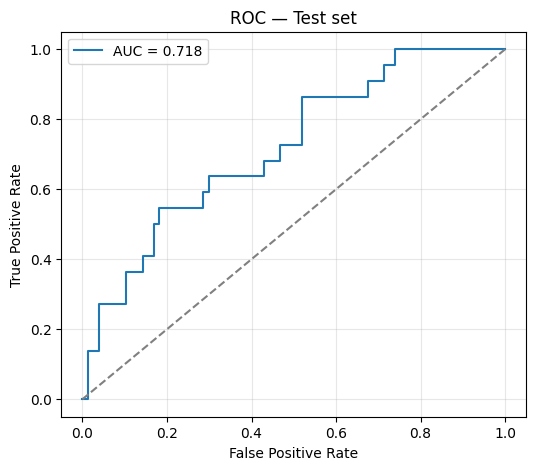

Saved final_model_transfer.keras


In [6]:
# ============================================================
# PASSO 7 — Treinamento e Avaliação (Transfer Learning - MobileNetV2)
# Segue o roteiro do professor, adaptado ao seu dataset e pastas.
# ============================================================

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# parameters
img_height, img_width = 150, 150
batch_size = 16
epochs_stage1 = 12
epochs_finetune = 12
base_dir = imgs_path / "dataset_final"

# --- Data generators (convert grayscale PNGs to RGB on the fly by reading 3 channels) ---
# We use color_mode='rgb' so Keras duplicates channels automatically; ensure your PNGs are single-channel grayscale,
# Keras will read them and produce 3 channels (duplicated) when color_mode='rgb' is used.

train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

train_generator = train_datagen.flow_from_directory(
    base_dir / "train",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

val_generator = val_test_datagen.flow_from_directory(
    base_dir / "val",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    base_dir / "test",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Train/Val/Test sizes:", train_generator.samples, val_generator.samples, test_generator.samples)
print("Class indices:", train_generator.class_indices)

# --- Build model (MobileNetV2 base + small head) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model_transfer_initial.keras", save_best_only=True, monitor='val_accuracy', mode='max')
]

# Stage 1: train head only
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_stage1,
    callbacks=callbacks
)

# Evaluate stage 1
loss1, acc1, auc1 = model.evaluate(test_generator, verbose=0)
print(f"Stage1 -> Test accuracy: {acc1:.4f} | AUC: {auc1:.4f}")

# Optional fine-tuning: unfreeze some last layers of base model
fine_tune = True
if fine_tune:
    # unfreeze some layers
    base_model.trainable = True

    # choose a fine-tune boundary
    fine_tune_at = len(base_model.layers) - 30  # unfreeze last 30 layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # recompile with lower lr
    model.compile(optimizer=optimizers.Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    callbacks_finetune = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint("best_model_transfer_finetuned.keras", save_best_only=True, monitor='val_accuracy', mode='max')
    ]

    history2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs_finetune,
        callbacks=callbacks_finetune
    )

    # Evaluate after fine-tune
    loss2, acc2, auc2 = model.evaluate(test_generator, verbose=0)
    print(f"After fine-tune -> Test accuracy: {acc2:.4f} | AUC: {auc2:.4f}")
else:
    print("Fine-tuning skipped.")

# --- Final evaluation and reports ---
y_true = test_generator.classes
y_proba = model.predict(test_generator).ravel()
y_pred = (y_proba > 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['BENIGN','MALIGNANT'], digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ROC/AUC
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
print(f"\nFinal ROC AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC — Test set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# save final model
model.save("final_model_transfer.keras")
print("Saved final_model_transfer.keras")